# Houston, we have a Salary!

### Executive Summary
The goal of this analysis is to 

### Project Overview

### Key Takeaways

### Data Dictionary

## Imports that will be utilized throughout this notebook



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# custom module imports
import Acquire as aq
import Prepare as pr
import Explore as ex

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

# import scaling methods
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split

# import modeling methods
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from scipy import stats

# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

## Acquire 

The dataset was acquired from the [Texas Tribune's website](https://salaries.texastribune.org/) and downloading all the data as a csv file. We will read in the csv as a Pandas dataframe using functions from the Acquire script.

The Acquire script contains functions to obtain the data, cache it as well as provide summary statistics.

In [2]:
# read data as df
df = aq.get_texas_data()

In [3]:
# quick look at data 
df.head()

,AGY,NAME,LASTNAME,FIRSTNAME,MI,JOBCLASS,JC TITLE,RACE,SEX,EMPTYPE,...,RATE,HRSWKD,MONTHLY,ANNUAL,STATENUM,duplicated,multiple_full_time_jobs,combined_multiple_jobs,summed_annual_salary,hide_from_search
0,101,SENATE,GILLIAM,STACEY,L,7101,LEG. OFFICIAL/ADMINISTRATOR,WHITE,FEMALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,0.0,20.0,8100.0,97200.0,339371,True,NaN,NaN,181200.0,NaN
1,104,LEGISLATIVE BUDGET BOARD,GILLIAM,STACEY,L,C160,COMMITTEE DIRECTOR,WHITE,FEMALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,0.0,20.0,7000.0,84000.0,339371,True,NaN,NaN,NaN,True
2,101,SENATE,NELSON,DAVID,,7101,LEG. OFFICIAL/ADMINISTRATOR,WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,0.0,20.0,9500.0,114000.0,193187,True,NaN,NaN,210000.0,NaN
3,104,LEGISLATIVE BUDGET BOARD,NELSON,DAVID,,P080,SENIOR BUDGET ADVISOR,WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,0.0,20.0,8000.0,96000.0,193187,True,NaN,NaN,NaN,True
4,101,SENATE,ROCHA,MARIE,S,7103,LEG. SERVICE/MAINTENANCE,HISPANIC,FEMALE,URF - UNCLASSIFIED REGULAR FULL-TIME,...,0.0,41.0,3365.4,40384.8,152257,True,NaN,True,NaN,NaN


In [4]:
# look at all columns in df
df.columns

Index(['AGY', 'NAME', 'LASTNAME', 'FIRSTNAME', 'MI', 'JOBCLASS', 'JC TITLE',
       'RACE', 'SEX', 'EMPTYPE', 'HIREDT', 'RATE', 'HRSWKD', 'MONTHLY',
       'ANNUAL', 'STATENUM', 'duplicated', 'multiple_full_time_jobs',
       'combined_multiple_jobs', 'summed_annual_salary', 'hide_from_search'],
      dtype='object')

In [5]:
# Check the different classes in each variable
df.nunique()

AGY                           111
NAME                          111
LASTNAME                    38227
FIRSTNAME                   23267
MI                             28
JOBCLASS                     1474
JC TITLE                     1406
RACE                            6
SEX                             2
EMPTYPE                         9
HIREDT                       6257
RATE                          207
HRSWKD                         47
MONTHLY                     39035
ANNUAL                      39037
STATENUM                   144727
duplicated                      1
multiple_full_time_jobs         1
combined_multiple_jobs          1
summed_annual_salary           11
hide_from_search                1
dtype: int64

- Displaying value_counts for the following will be helpful as these variables seem to have a few classes:
    - `RACE`
    - `SEX`
    - `EMPTYPE`
- Other variables besides the above seem to be continuous.

In [3]:
# summarize the df and its columns
aq.get_data_summary(df)

The dataframe has 144738 rows and 21 columns.

-------------------
There are total of 723537 missing values in the entire dataframe.

-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144738 entries, 0 to 144737
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   AGY                      144738 non-null  int64  
 1   NAME                     144738 non-null  object 
 2   LASTNAME                 144738 non-null  object 
 3   FIRSTNAME                144738 non-null  object 
 4   MI                       144738 non-null  object 
 5   JOBCLASS                 144738 non-null  object 
 6   JC TITLE                 144738 non-null  object 
 7   RACE                     144738 non-null  object 
 8   SEX                      144738 non-null  object 
 9   EMPTYPE                  144738 non-null  object 
 10  HIREDT                   144738 non-null  object 
 11  RATE           

## Takeaways

- The dataframe has a nice set of observations.
- Annual salary is our target variable
- Very few values in duplicated, multiple_full_time_jobs, combined_multiple_jobs and summed_annual_salary. There are no null values in any other columns
- Each observation is an employee for the Texas State Government.
- AGY column is the id for the department the employee works with.
- Most variables are upper case which should be converted to lower case.
- The column `MONTHLY` is the monthly salary.
    - The target variable `ANNUAL` is derived from this column.
- Most variables are object data types and would need to be one hot encoded in order to be utilized for modeling.
- Highest annual salary is 553,500 USD while the minimum is 600 USD.
- Max hours worked is 80 while minimum is 2.
- Highest proportion of employees is white and the lowest proportion are Native Americans.
- There are more females than males in the dataset.
- Most employees are classified regular full time.

## Prepare

During this phase of the pipeline, the main focus was on cleaning and preparing the data for analysis and modeling.

Functions from our prepare script were utilized to perform the following actions:

- drop duplicate rows
- change column names to lower case and remove white space
- remove white space from columns with object dtypes
- drop the following columns as they do not provide any additional information or value
    - `statenum`
    - `jobclass`
    - `mi`
    -`rate` 
    -`duplicated`
    - `multiple_full_time_jobs`
    - `combined_multiple_jobs`
    -`summed_annual_salary`
    -`hide_from_search`
- rename columns for ease of workflow
- change hire date to date time format
- drop rows with erroneous futuristic hire dates
- one hot encode object dtype variables to create numeric features which can be utilized in models
- create bins for tenure in years
- split the dataframe into train, test and split tests

### Exploring Univariate Distributions

The explore_univariate function from our explore script is used to create bar plots for categorical variables and histograms and boxplot for continuous variables. We will perform univariate exploration to visualize inidvaidual variable distributions before we prepare and split the dataframe.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144738 entries, 0 to 144737
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   AGY                      144738 non-null  int64  
 1   NAME                     144738 non-null  object 
 2   LASTNAME                 144738 non-null  object 
 3   FIRSTNAME                144738 non-null  object 
 4   MI                       144738 non-null  object 
 5   JOBCLASS                 144738 non-null  object 
 6   JC TITLE                 144738 non-null  object 
 7   RACE                     144738 non-null  object 
 8   SEX                      144738 non-null  object 
 9   EMPTYPE                  144738 non-null  object 
 10  HIREDT                   144738 non-null  object 
 11  RATE                     144738 non-null  float64
 12  HRSWKD                   144738 non-null  float64
 13  MONTHLY                  144738 non-null  float64
 14  ANNU

In [8]:
df.nunique()

AGY                           111
NAME                          111
LASTNAME                    38227
FIRSTNAME                   23267
MI                             28
JOBCLASS                     1474
JC TITLE                     1406
RACE                            6
SEX                             2
EMPTYPE                         9
HIREDT                       6257
RATE                          207
HRSWKD                         47
MONTHLY                     39035
ANNUAL                      39037
STATENUM                   144727
duplicated                      1
multiple_full_time_jobs         1
combined_multiple_jobs          1
summed_annual_salary           11
hide_from_search                1
dtype: int64

In [4]:
cat_vars = ['RACE', 'SEX', 'EMPTYPE']
quant_vars = ['MONTHLY','ANNUAL']

Bar Plot of RACE


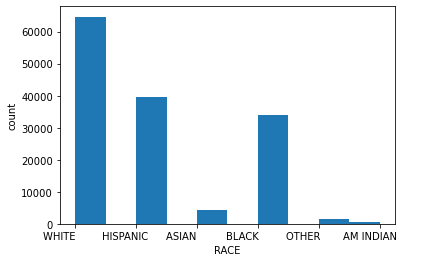

Bar Plot of SEX


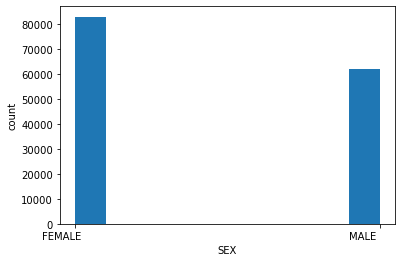

Bar Plot of EMPTYPE


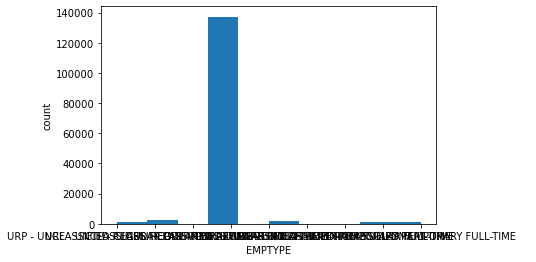

Distribution of MONTHLY


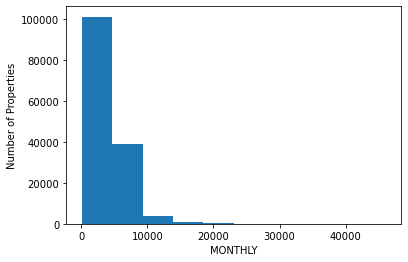

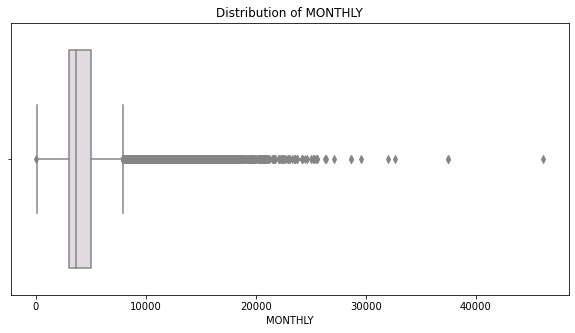

Distribution of ANNUAL


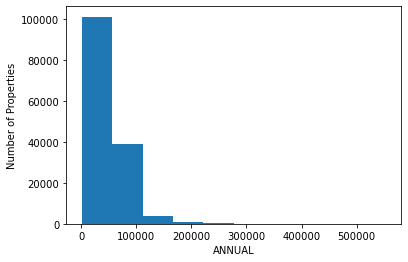

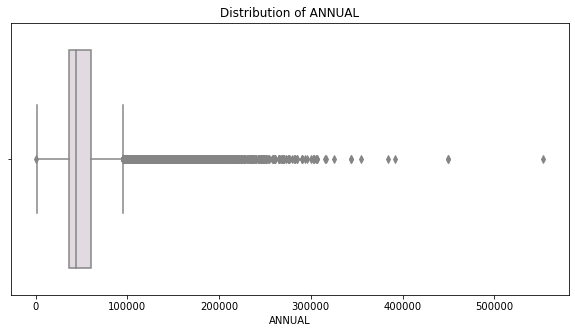

In [5]:
ex.explore_univariate(df, cat_vars, quant_vars)

### Takeaways

- Highest number of white employees
- There are more female employees than male
- Monthly and Annual Salary have right skewed distributions due to upper end outliers



Now we will call functions from our prepare script to prepare the data for further exploration and modeling.

In [6]:
df = pr.prepare_tex(df)

In [7]:
# create new encoded features
df = pr.create_features(df)

Looking At Our Maximum Age and Minimum Age to Make Some Age Bins

Max: 49.8, Min: 0.0

----------------------------

Visualizing Years of Tenure Column To Help with Binning



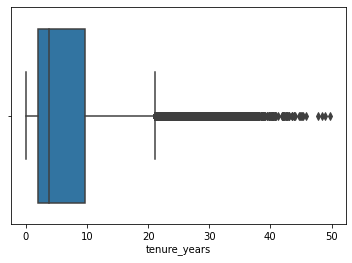


----------------------------

Looking At Our Years of Tenure Bins Value Counts
1    83012
2    27330
3    25513
4     8875
Name: tenure_years_bins, dtype: int64

----------------------------



In [8]:
# create bins for tenure
df = pr.make_bins_and_feats(df)

In [9]:
# look at prepared df with new features
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144730 entries, 0 to 144737
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   agency_id          144730 non-null  int64         
 1   agency             144730 non-null  object        
 2   lastname           144730 non-null  object        
 3   firstname          144730 non-null  object        
 4   title              144730 non-null  object        
 5   race               144730 non-null  object        
 6   sex                144730 non-null  object        
 7   emptype            144730 non-null  object        
 8   hire_date          144730 non-null  datetime64[ns]
 9   hours_worked       144730 non-null  float64       
 10  monthly_salary     144730 non-null  float64       
 11  annual_salary      144730 non-null  float64       
 12  is_female          144730 non-null  int64         
 13  is_white           144730 non-null  int64   

In [10]:
# split the df to prevent data leakage
train, validate, test = pr.split_data(df)

Making Sure Our Shapes Look Good
Train: (81048, 29), Validate: (34736, 29), Test: (28946, 29)


- The split dataframes have different number of rows but the same number of columns which is what we are looking for.

### Bivariate Exploration

We will explore the interaction of variables using only on our train split.

In [11]:
# quick peak at train split
train.head()

,agency_id,agency,lastname,firstname,title,race,sex,emptype,hire_date,hours_worked,...,tenure_years,is_elected,is_director,is_unclassified,is_parttime,tenure_years_bins,0-5_years,5-10_years,10-20_years,>20_years
125096,696,TEXAS DEPARTMENT OF CRIMINAL JUSTICE,OKECHI,VICTOR,CORREC OFFICER IV,BLACK,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,2017-02-06,40.0,...,4.4,0,0,0,0,1,1,0,0,0
42845,529,HEALTH AND HUMAN SERVICES COMMISSION,EKRAM,NIDAA,PROGRAM SPECIALIST V,ASIAN,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,2020-09-08,40.0,...,0.8,0,0,0,0,1,1,0,0,0
117530,696,TEXAS DEPARTMENT OF CRIMINAL JUSTICE,ISIORHOVOJA,ANDREW,CORREC OFFICER IV,BLACK,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,2020-03-30,40.0,...,1.2,0,0,0,0,1,1,0,0,0
26227,405,DEPARTMENT OF PUBLIC SAFETY,NETT,ROBERT,"SERGEANT, DPS",WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,2009-09-27,40.0,...,11.8,0,0,0,0,3,0,0,1,0
113713,696,TEXAS DEPARTMENT OF CRIMINAL JUSTICE,GARZA,AMANDA,PAROLE OFFCR II,HISPANIC,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,2016-08-15,40.0,...,4.9,0,0,0,0,1,1,0,0,0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81048 entries, 125096 to 89798
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   agency_id          81048 non-null  int64         
 1   agency             81048 non-null  object        
 2   lastname           81048 non-null  object        
 3   firstname          81048 non-null  object        
 4   title              81048 non-null  object        
 5   race               81048 non-null  object        
 6   sex                81048 non-null  object        
 7   emptype            81048 non-null  object        
 8   hire_date          81048 non-null  datetime64[ns]
 9   hours_worked       81048 non-null  float64       
 10  monthly_salary     81048 non-null  float64       
 11  annual_salary      81048 non-null  float64       
 12  is_female          81048 non-null  int64         
 13  is_white           81048 non-null  int64         
 14  i

In [41]:
# assign categorical and quantitative(continuous) variables
cat_vars1 = ['race','sex','is_female','is_white','is_hispanic','is_black','is_BIPOC','race_encoded',
           'is_elected','is_director','is_unclassified','is_parttime','tenure_years_bins','0-5_years',
           '5-10_years', '10-20_years', '>20_years']
quant_vars1 = ['agency_id','hours_worked','monthly_salary','annual_salary']

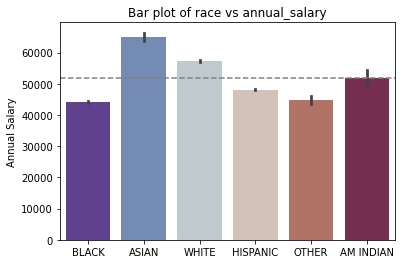

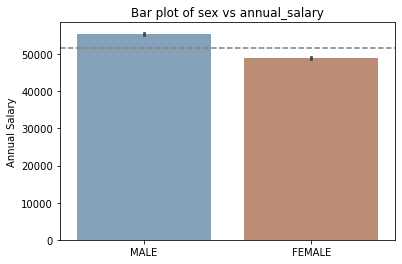

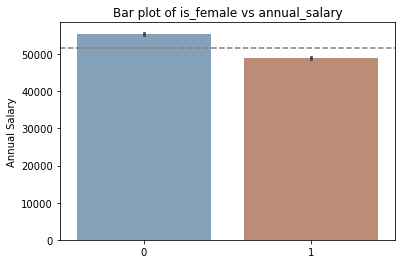

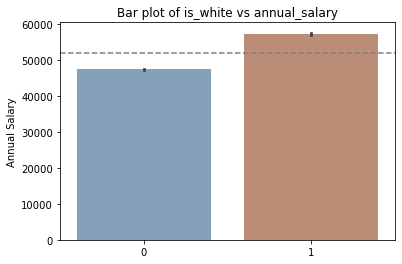

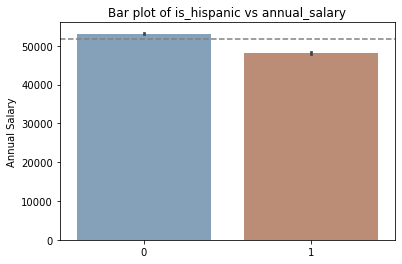

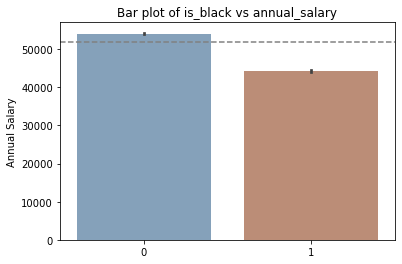

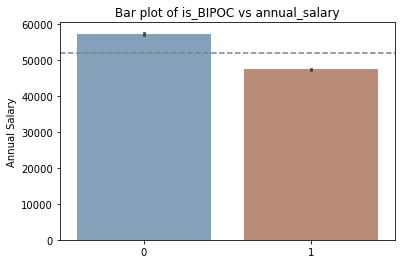

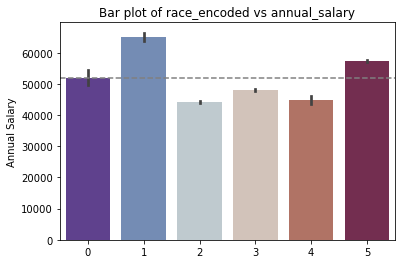

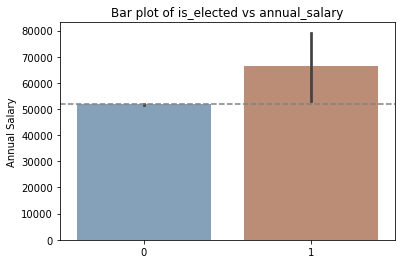

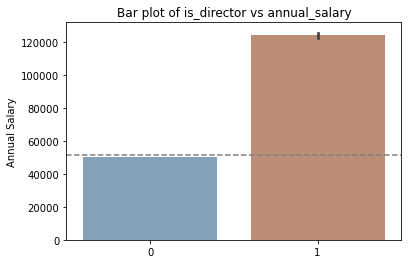

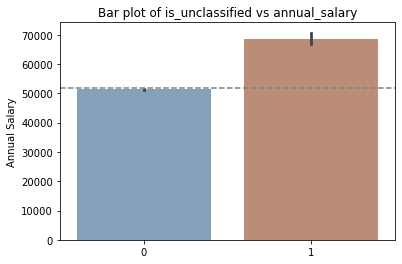

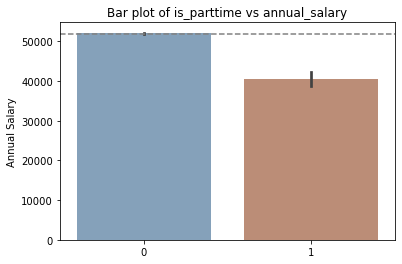

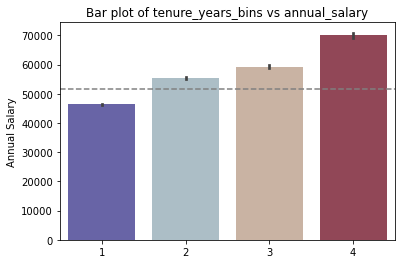

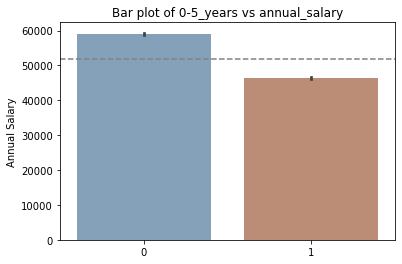

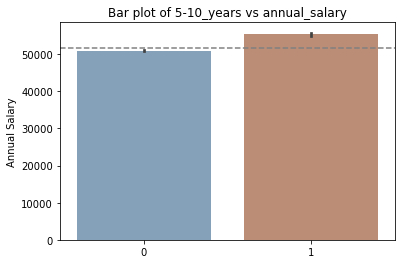

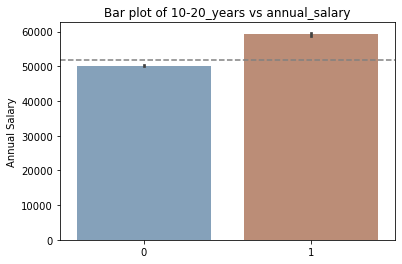

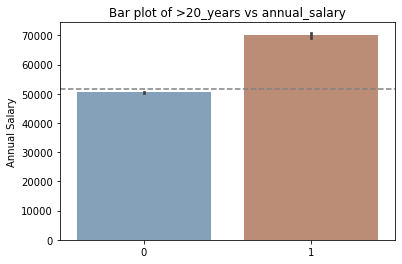

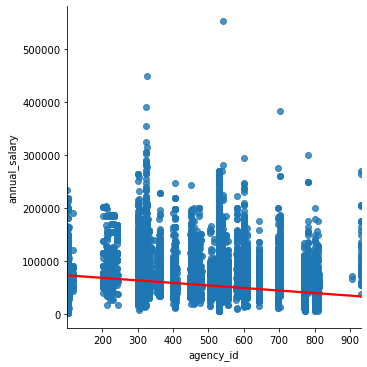

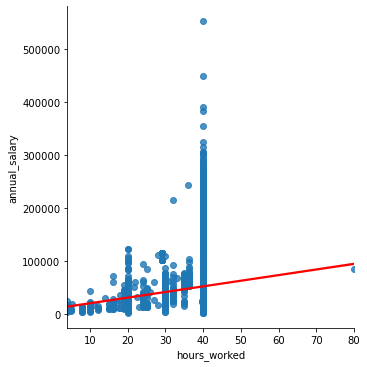

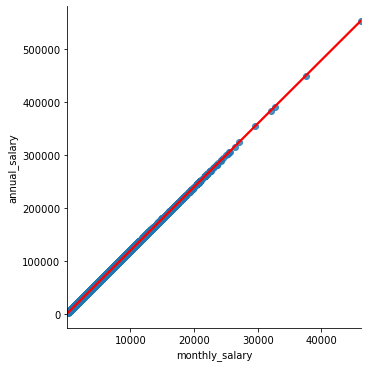

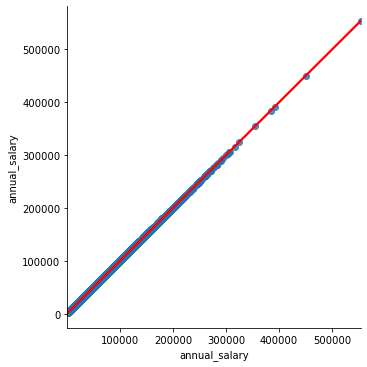

In [42]:
# call the function to create barplots and scatterplots
ex.explore_bivariate(train, 'annual_salary', cat_vars1, quant_vars1)

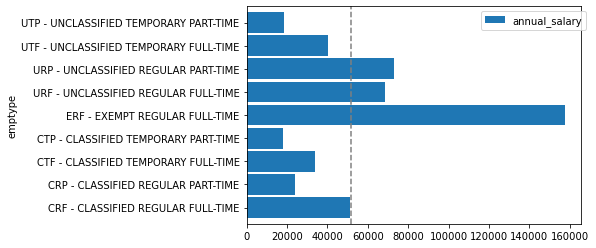

In [40]:
# to visualize emptype vs annual salary better
overall_mean = df['annual_salary'].mean()
pd.pivot_table(train, values='annual_salary', index='emptype').plot.barh(width=0.9)
plt.axvline(overall_mean, ls = '--', color = 'grey')
plt.legend(bbox_to_anchor=(1.03, 1))
plt.show()

### Takeaways

- Employees who are white or asian have annual salaries above the average
- Asians have the highest annual salary
- Black and other races seem to have the lowest annual salary
- Males have a higher annual salary than women
- Exempt regular full time employees have the highest annual salaries
- Unclassified Regular Employees have lower salaries than classified employees
- Elected employees have hiigher annual salary than non elected employees
- Employees with under 5 years' tenure have lower salaries than those who have longer tenures

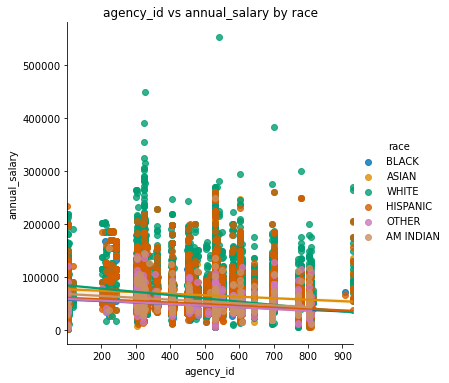

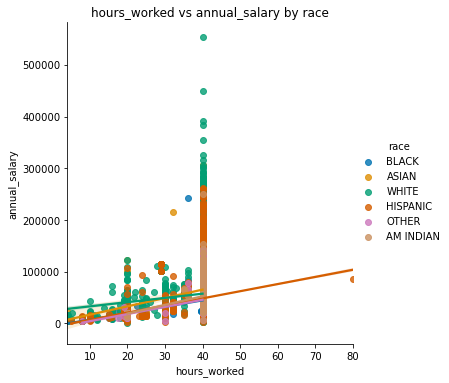

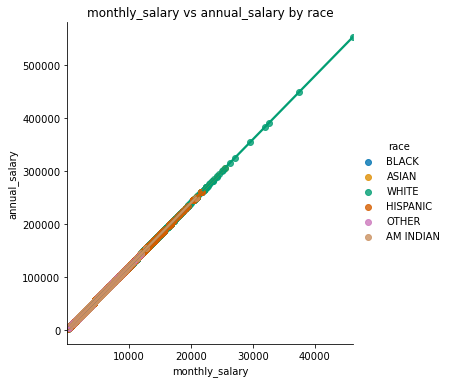

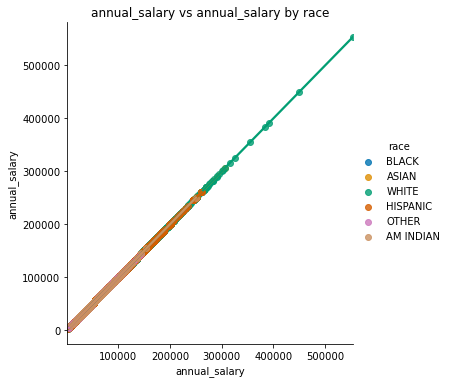

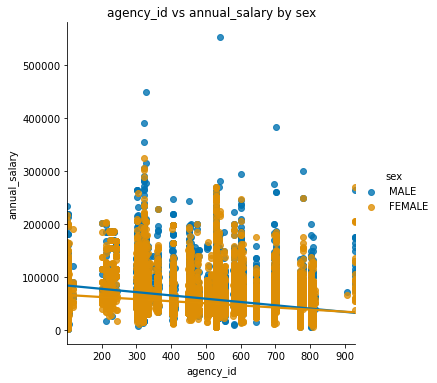

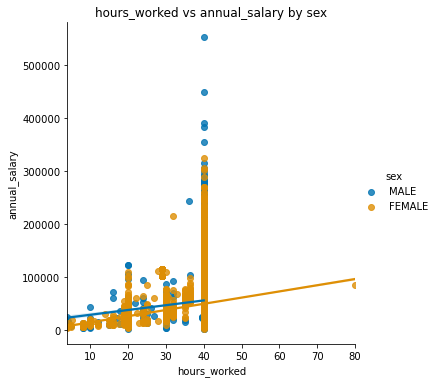

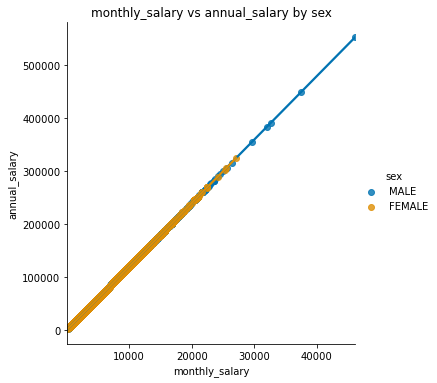

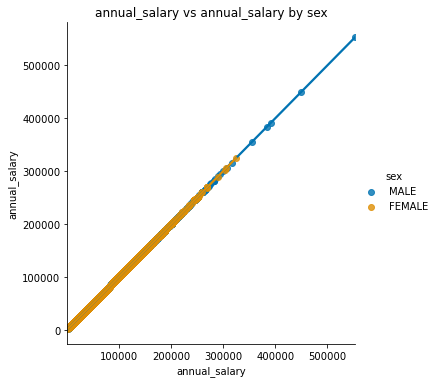

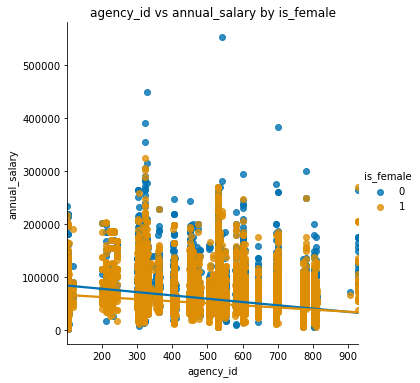

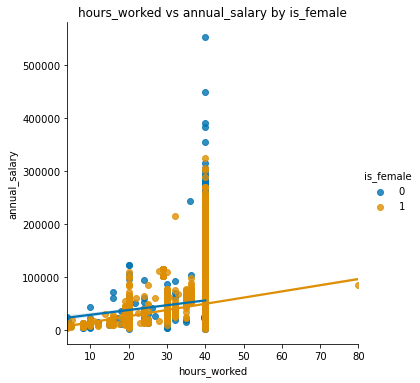

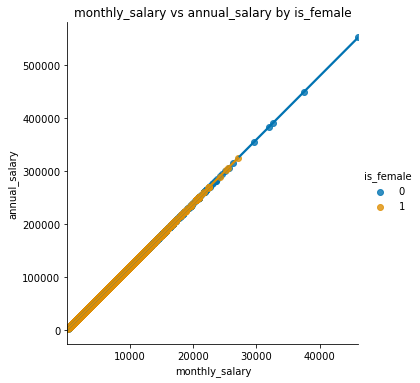

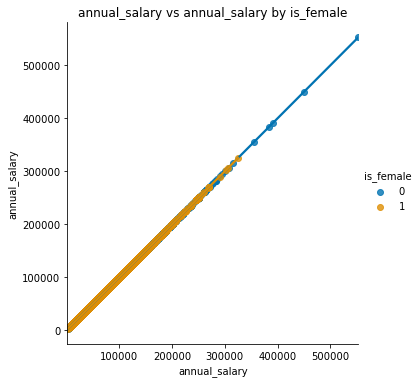

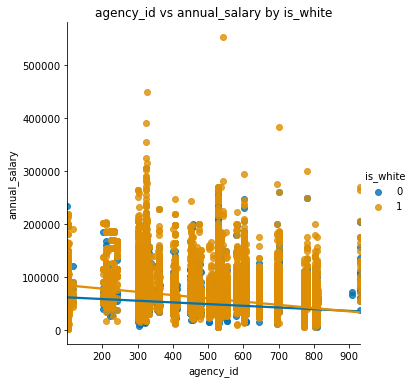

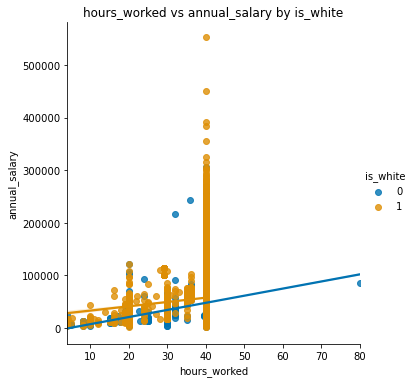

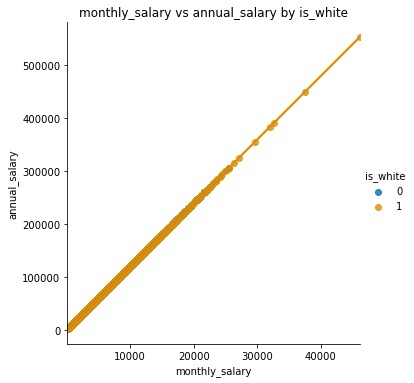

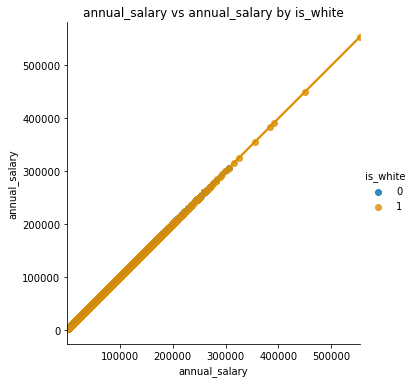

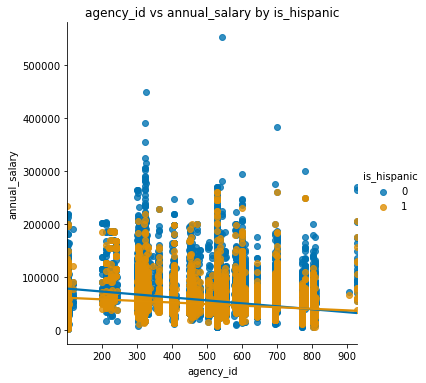

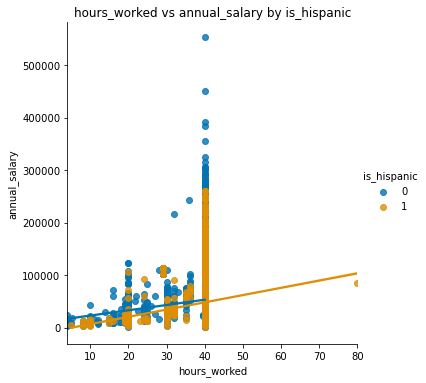

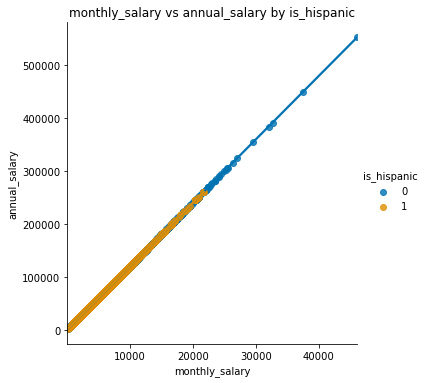

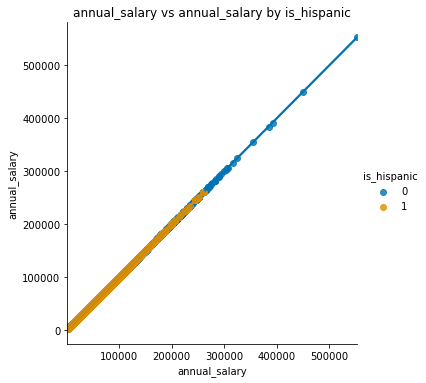

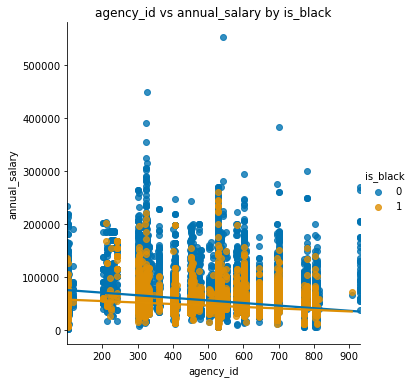

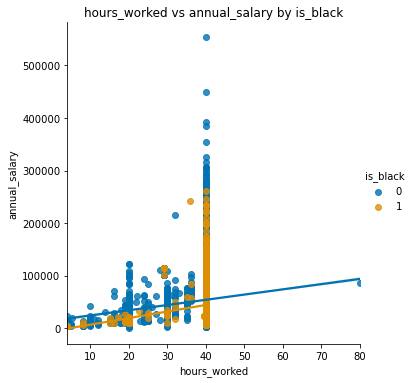

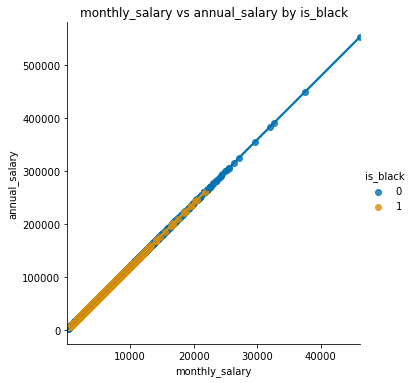

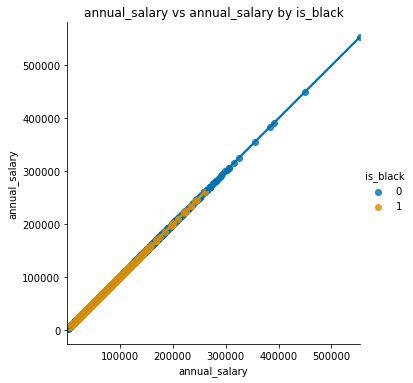

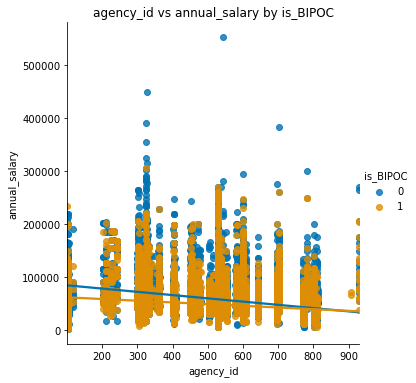

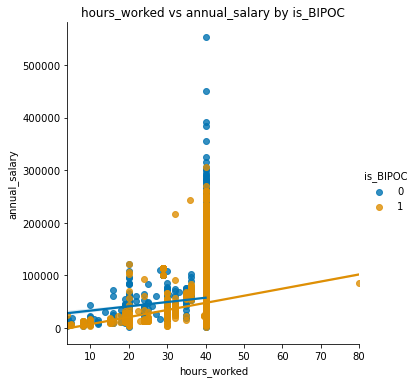

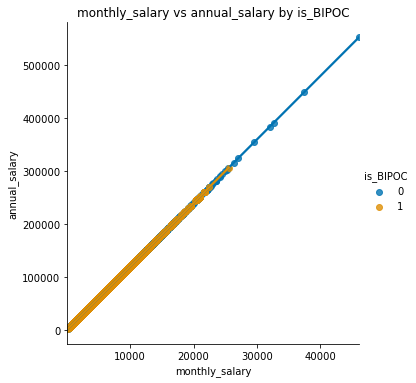

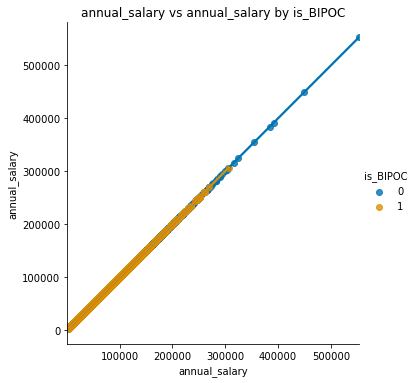

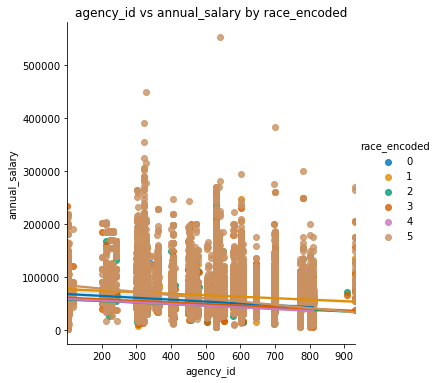

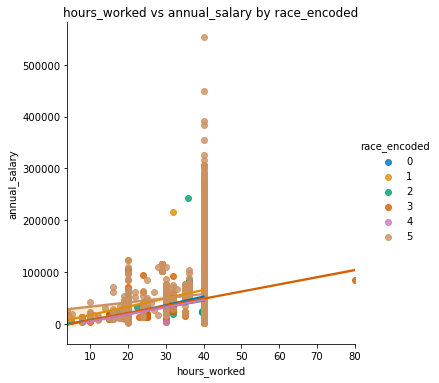

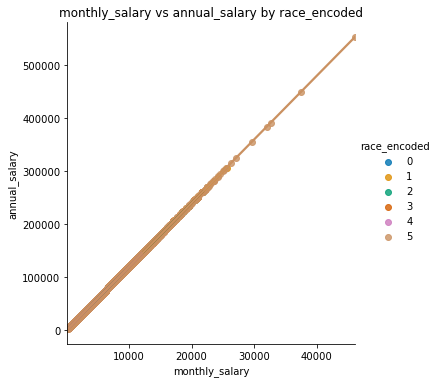

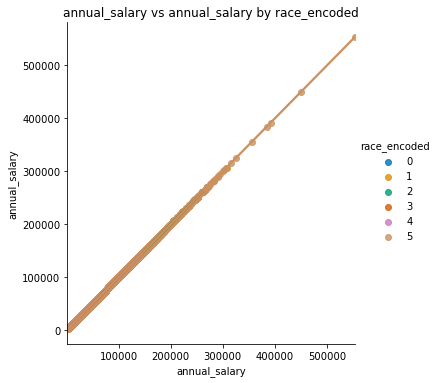

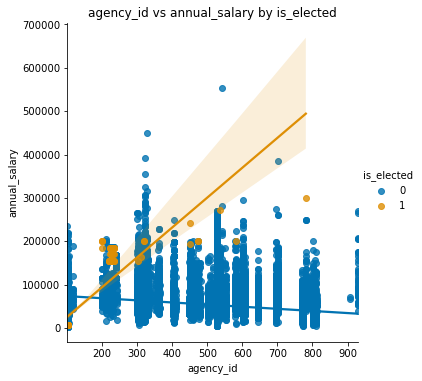

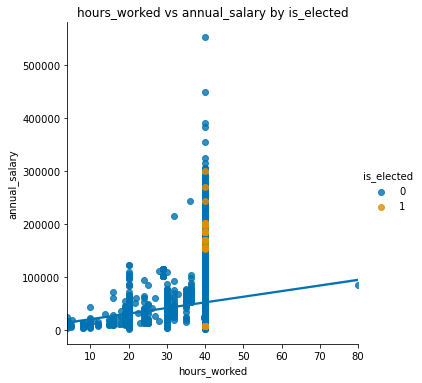

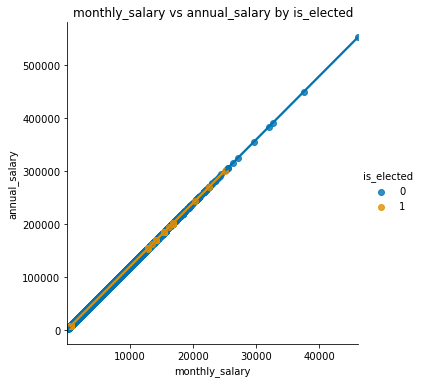

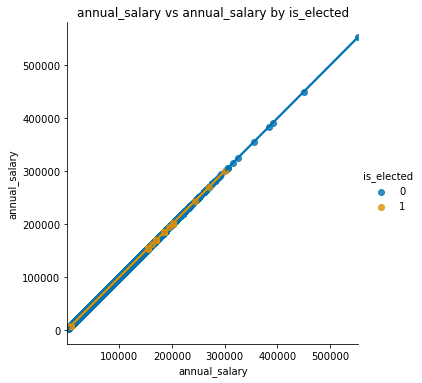

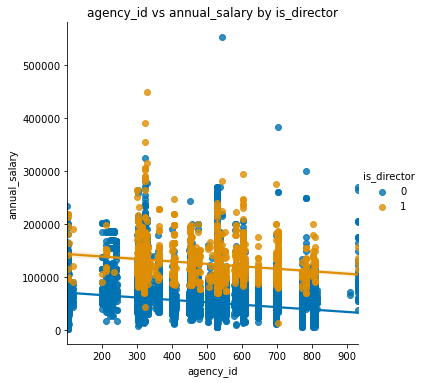

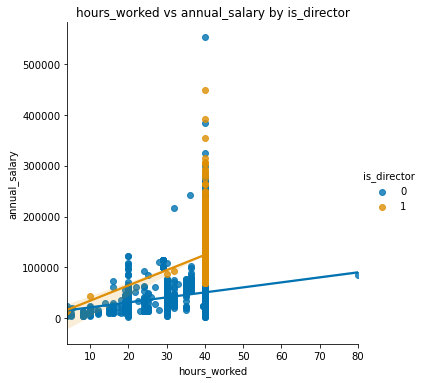

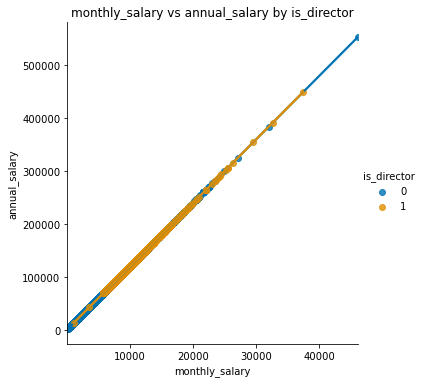

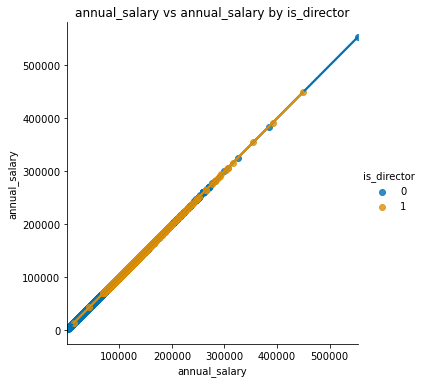

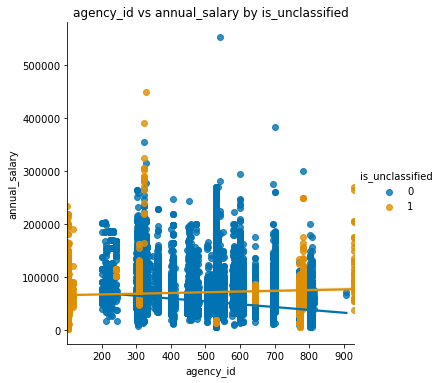

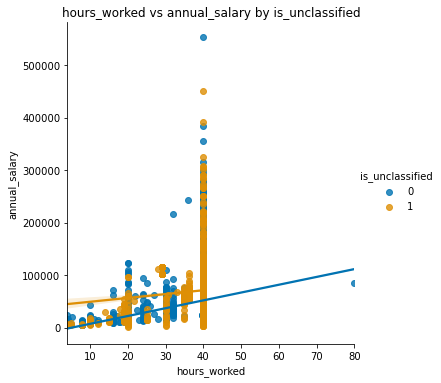

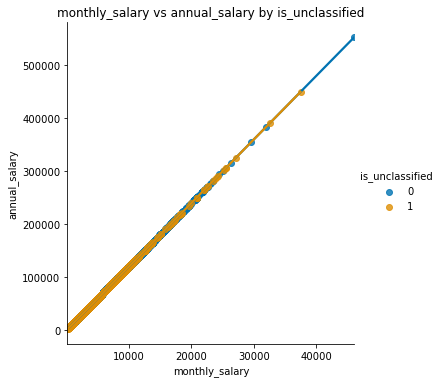

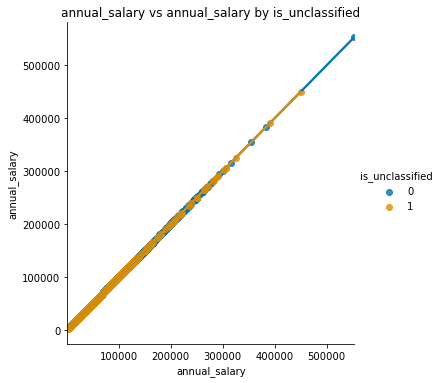

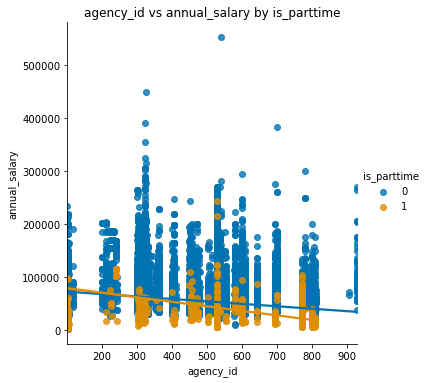

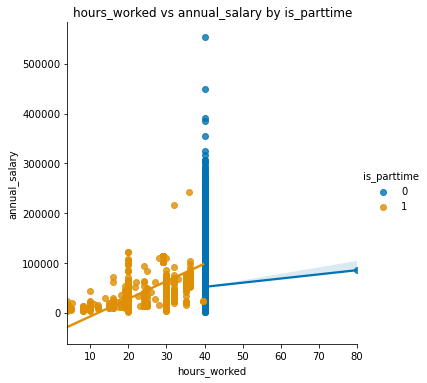

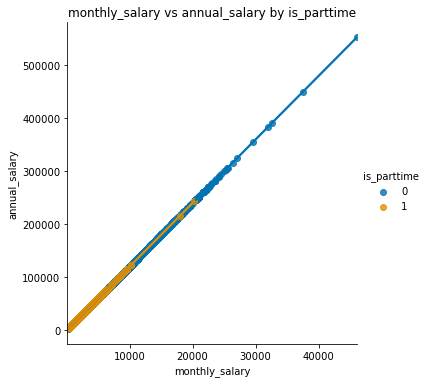

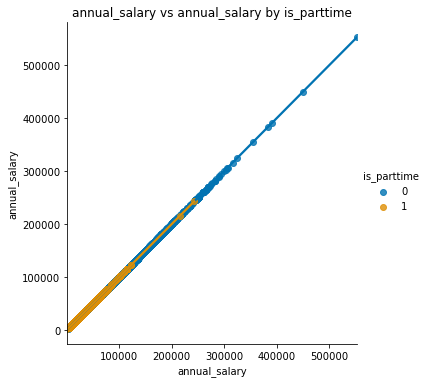

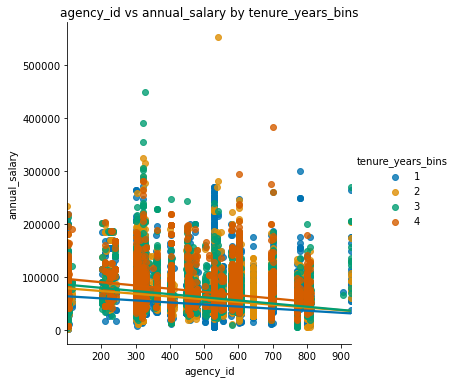

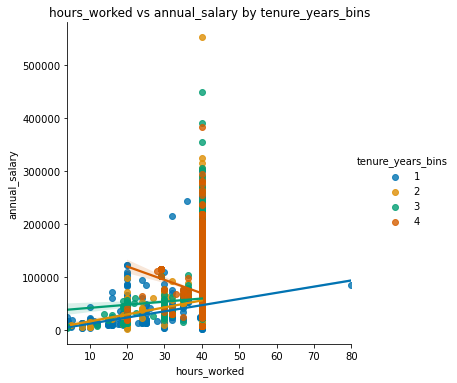

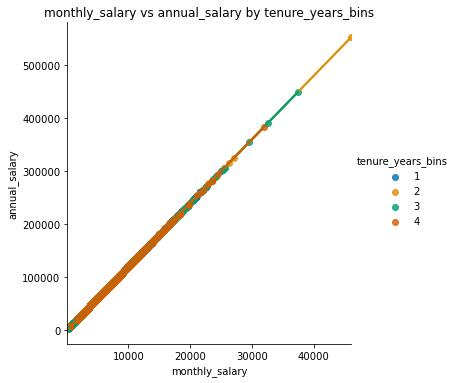

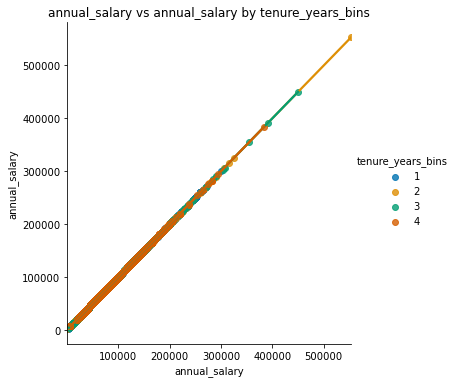

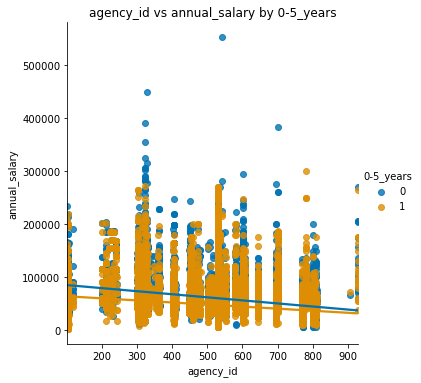

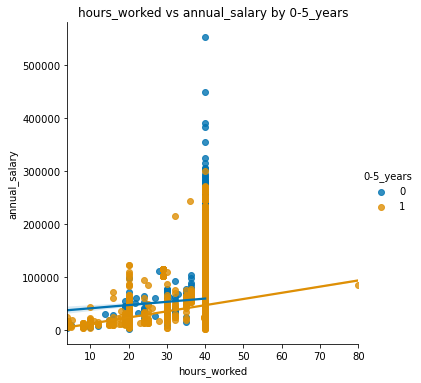

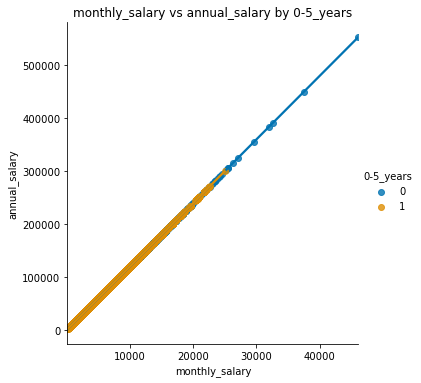

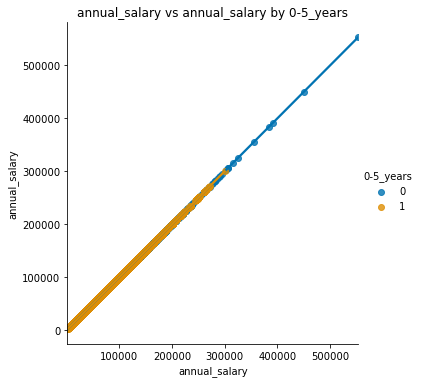

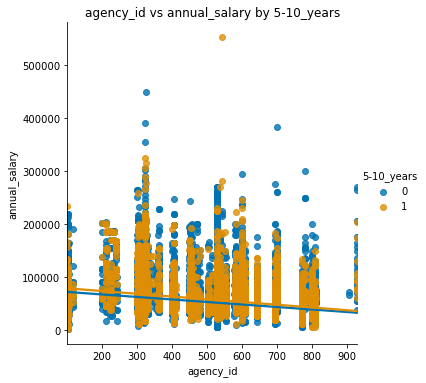

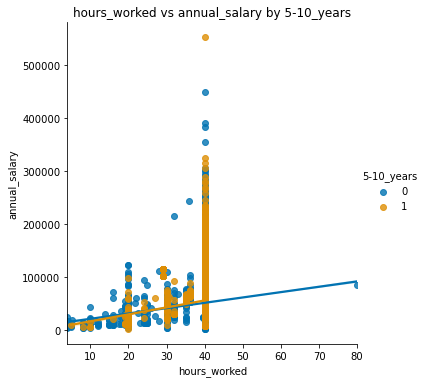

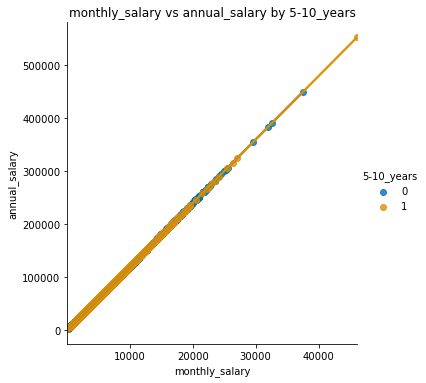

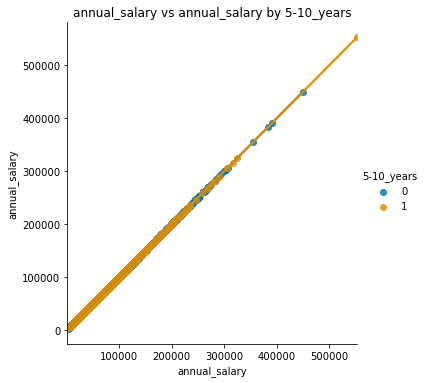

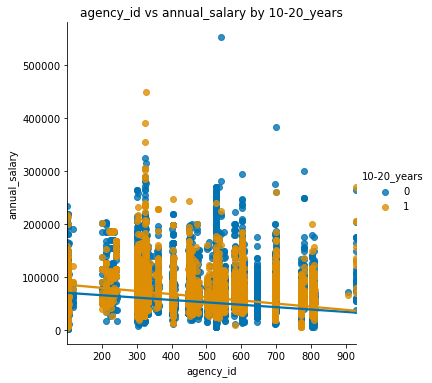

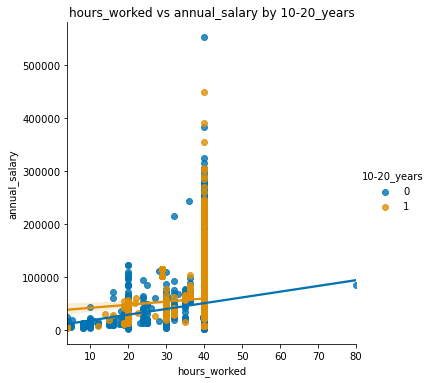

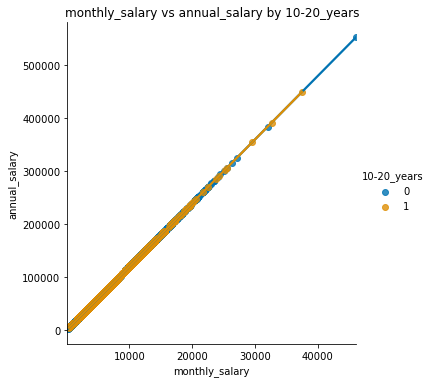

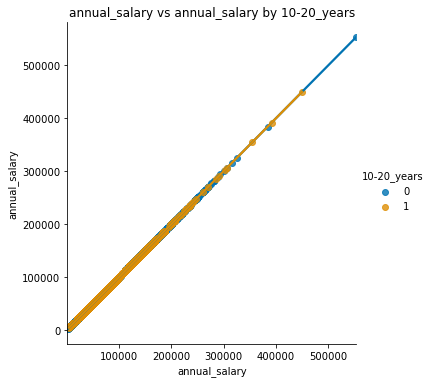

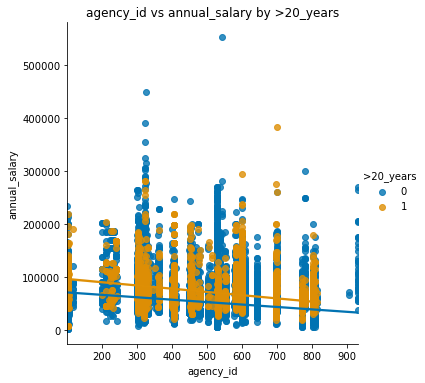

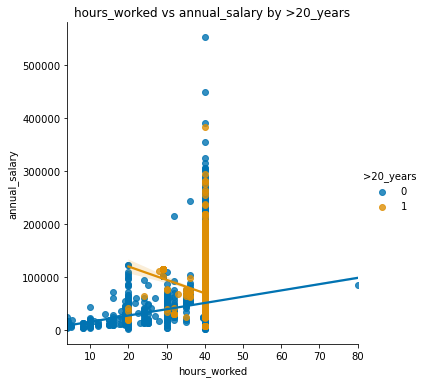

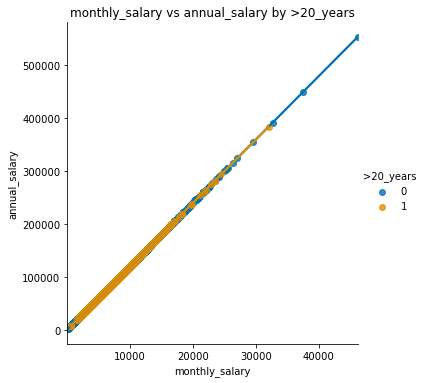

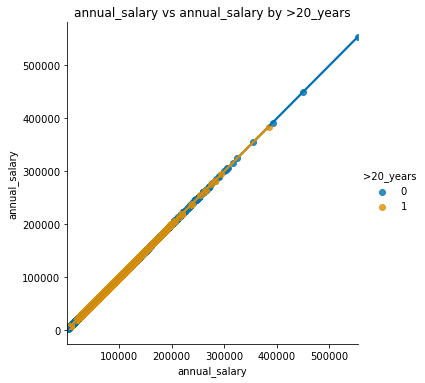

In [43]:
ex.explore_multivariate(train, 'annual_salary', cat_vars1, quant_vars1)

### Takeaways

- Highest annual salary for white employees is in agency 320
- Most employees work 40hours
- annual salary is derived from monthly salary
- Females have lower annual salaries than their male coworkers in the same department
- Highest annual salary for black employees is under 30,000
- Highest annual salary for hispanic employees is under 300,000
- All departments have people of color but non BIPOC have higher annual salaries
- Elected employees have higher salaries than non elected employees
- Employees who are Directors have higher annual salaries than those who are not
- Directors usually work full time hours
- Most Employees are classified 
- There are fewer part time employees than full time